In [2]:
# ga_predict_helpers.py
import json, numpy as np, pandas as pd, torch, torch.nn as nn, torch.nn.functional as F, joblib
from pathlib import Path
from typing import Optional, Dict, Tuple

# ===== Match your training code =====
TIME_COL   = "TIMESTAMP"
TARGET_COL = "TARGETVAR"
BASE_FEATS = ["U10", "V10", "U100", "V100"]

LAGS_Y       = [1, 3, 6, 12, 24]
LAGS_SPEED   = [1, 3, 6]
ROLLS_Y      = [6, 12, 24]
TURB_WINS    = [6, 12, 24, 48]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- FE (same as training) ----------
def add_engineered_features(df: pd.DataFrame, include_turbulence: bool) -> pd.DataFrame:
    out = df.copy()
    out["speed10"]  = np.sqrt(out["U10"]**2  + out["V10"]**2)
    out["speed100"] = np.sqrt(out["U100"]**2 + out["V100"]**2)
    d10  = np.arctan2(out["V10"],  out["U10"])
    d100 = np.arctan2(out["V100"], out["U100"])
    out["dir10_sin"], out["dir10_cos"]   = np.sin(d10),  np.cos(d10)
    out["dir100_sin"], out["dir100_cos"] = np.sin(d100), np.cos(d100)
    out["shear_speed"] = out["speed100"] - out["speed10"]
    veer = d100 - d10
    out["veer_sin"], out["veer_cos"] = np.sin(veer), np.cos(veer)

    out["hour"] = pd.to_datetime(out[TIME_COL]).dt.hour
    out["day"]  = pd.to_datetime(out[TIME_COL]).dt.dayofyear
    out["hour_sin"] = np.sin(2*np.pi*out["hour"]/24.0)
    out["hour_cos"] = np.cos(2*np.pi*out["hour"]/24.0)
    out["day_sin"]  = np.sin(2*np.pi*out["day"]/366.0)
    out["day_cos"]  = np.cos(2*np.pi*out["day"]/366.0)

    for L in LAGS_Y:
        out[f"y_lag{L}"] = out[TARGET_COL].shift(L)
    for W in ROLLS_Y:
        out[f"y_roll{W}"] = out[TARGET_COL].shift(1).rolling(W, min_periods=W).mean()
    for L in LAGS_SPEED:
        out[f"speed10_lag{L}"]  = out["speed10"].shift(L)
        out[f"speed100_lag{L}"] = out["speed100"].shift(L)

    if include_turbulence:
        for W in TURB_WINS:
            s10  = out["speed10"].shift(1).rolling(W, min_periods=W)
            s100 = out["speed100"].shift(1).rolling(W, min_periods=W)
            out[f"speed10_std{W}"]  = s10.std()
            out[f"speed100_std{W}"] = s100.std()
            out[f"speed10_rng{W}"]  = s10.max() - s10.min()
            out[f"speed100_rng{W}"] = s100.max() - s100.min()
            out[f"y_std{W}"]        = out[TARGET_COL].shift(1).rolling(W, min_periods=W).std()
    return out

def build_feat_list(include_turbulence: bool):
    base = (
        BASE_FEATS +
        ["speed10","speed100","dir10_sin","dir10_cos","dir100_sin","dir100_cos",
         "shear_speed","veer_sin","veer_cos","hour_sin","hour_cos","day_sin","day_cos"] +
        [f"y_lag{L}" for L in LAGS_Y] +
        [f"y_roll{W}" for W in ROLLS_Y] +
        [f"speed10_lag{L}" for L in LAGS_SPEED] +
        [f"speed100_lag{L}" for L in LAGS_SPEED]
    )
    if not include_turbulence:
        return base
    turb = (
        [f"speed10_std{W}"  for W in TURB_WINS] +
        [f"speed100_std{W}" for W in TURB_WINS] +
        [f"speed10_rng{W}"  for W in TURB_WINS] +
        [f"speed100_rng{W}" for W in TURB_WINS] +
        [f"y_std{W}"        for W in TURB_WINS]
    )
    return base + turb

# ---------- No-class components (same shapes as training) ----------
def build_components(input_size, hidden, layers, dropout, bidir):
    lstm = nn.LSTM(input_size=input_size,
                   hidden_size=hidden,
                   num_layers=layers,
                   batch_first=True,
                   dropout=dropout if layers > 1 else 0.0,
                   bidirectional=bidir).to(DEVICE)
    out_size = hidden * (2 if bidir else 1)
    norm = nn.LayerNorm(out_size).to(DEVICE)
    lin1 = nn.Linear(out_size, out_size).to(DEVICE)
    lin2 = nn.Linear(out_size, 1).to(DEVICE)
    return {"lstm": lstm, "norm": norm, "lin1": lin1, "lin2": lin2, "dropout": dropout}

def forward_pass(x, mods, training: bool):
    o, _ = mods["lstm"](x)             # (B,T,H*)
    last = o[:, -1, :]
    last = mods["norm"](last)
    last = F.gelu(mods["lin1"](last))
    last = F.dropout(last, p=mods["dropout"], training=training)
    yhat = mods["lin2"](last)          # (B,1)
    return yhat

def set_train_mode(mods, train: bool):
    for m in [mods["lstm"], mods["norm"], mods["lin1"], mods["lin2"]]:
        m.train(mode=train)

# ---------- Artifacts ----------
def load_artifacts(model_root: str):
    root = Path(model_root)
    with open(root / "..//BiGLSTM//best_params_ga.json", "r") as f:
        best_params = json.load(f)
    xsc = joblib.load(root / "../BiGLSTM/x_scaler_ga.pkl")
    ysc = joblib.load(root / "../BiGLSTM/y_scaler_ga.pkl")
    state_dicts = torch.load(root / "../BiGLSTM/bilstm_ga_best_noclass.pt", map_location=DEVICE)
    # state_dicts is a dict: {"lstm": ..., "norm": ..., "lin1": ..., "lin2": ...}
    return best_params, xsc, ysc, state_dicts

# ---------- History requirements ----------
def max_required_lag(turb_on: bool) -> int:
    m = max(max(LAGS_Y), max(ROLLS_Y), max(LAGS_SPEED))
    if turb_on:
        m = max(m, max(TURB_WINS))
    return m  # 24 if no turbulence, else 48

def required_history_rows(lookback: int, turb_on: bool) -> int:
    return max_required_lag(turb_on) + int(lookback)

# ---------- Core helpers ----------
def _prepare_window_from_history(df_hist: pd.DataFrame,
                                 best_params: dict,
                                 xsc, ysc,
                                 future_weather: Optional[Dict[str, float]] = None
                                 ) -> Tuple[torch.Tensor, pd.Timestamp]:
    """
    Build the model input window (1, lookback, n_feats) for t+1 and return (xb, next_timestamp).
    """
    lookback = int(best_params["lookback"])
    turb_on  = bool(best_params["turb_on"])
    log_tgt  = bool(best_params["log_target"])

    df_hist = df_hist.copy().sort_values(TIME_COL).reset_index(drop=True)

    # 1) build a placeholder next-hour exogenous row
    if future_weather is None:
        fut = df_hist.iloc[[-1]][[TIME_COL] + BASE_FEATS].copy()
        fut[TIME_COL] = pd.to_datetime(fut[TIME_COL]) + pd.Timedelta(hours=1)
    else:
        fut = pd.DataFrame([{
            TIME_COL: pd.to_datetime(df_hist[TIME_COL].iloc[-1]) + pd.Timedelta(hours=1),
            "U10": future_weather["U10"], "V10": future_weather["V10"],
            "U100": future_weather["U100"], "V100": future_weather["V100"],
        }])
    fut[TARGET_COL] = np.nan

    work = pd.concat([df_hist[[TIME_COL, TARGET_COL] + BASE_FEATS], fut], ignore_index=True)

    # 2) FE (lags/rolls/turbulence identical to training)
    dfe = add_engineered_features(work, include_turbulence=turb_on)

    # 3) We will take the window from the penultimate row's features (history),
    #    because the last row is the target t+1 (which has lags computed).
    feat_cols = build_feat_list(include_turbulence=turb_on)
    dfe_hist = dfe.iloc[:-1].dropna().reset_index(drop=True)
    if len(dfe_hist) < lookback:
        need = required_history_rows(lookback, turb_on)
        raise ValueError(f"Not enough valid rows after FE to form lookback={lookback} window. "
                         f"Provide ≥ {need} rows of raw history. "
                         f"Have only {len(df_hist)} pre-FE rows.")

    X_hist = dfe_hist[feat_cols].to_numpy(np.float32)
    X_hist_s = xsc.transform(X_hist)

    window = X_hist_s[-lookback:, :]  # (lookback, n_feats)
    xb = torch.from_numpy(window[None, ...]).float().to(DEVICE)

    next_ts = pd.to_datetime(df_hist[TIME_COL].iloc[-1]) + pd.Timedelta(hours=1)
    return xb, next_ts, ysc, log_tgt

def predict_next_from_history(model_root: str,
                              df_history: pd.DataFrame,
                              future_weather: Optional[Dict[str, float]] = None) -> Tuple[pd.Timestamp, float]:
    """
    df_history: last N rows with columns [TIMESTAMP, TARGETVAR, U10, V10, U100, V100]
    future_weather: optional dict with next-hour exogenous values; if None, holds last known.
    """
    best, xsc, ysc, state = load_artifacts(model_root)

    # prepare input window
    xb, next_ts, ysc, log_tgt = _prepare_window_from_history(df_history, best, xsc, ysc, future_weather)

    # rebuild modules & load weights
    input_size = xb.shape[-1]
    mods = build_components(input_size, best["hidden"], best["layers"], best["dropout"], best["bidir"])
    mods["lstm"].load_state_dict(state["lstm"])
    mods["norm"].load_state_dict(state["norm"])
    mods["lin1"].load_state_dict(state["lin1"])
    mods["lin2"].load_state_dict(state["lin2"])
    set_train_mode(mods, False)

    with torch.no_grad():
        yhat_s = forward_pass(xb, mods, training=False).cpu().numpy()  # scaled
    yhat = ysc.inverse_transform(yhat_s).ravel()[0]
    if log_tgt:
        yhat = np.expm1(yhat)
    return next_ts, float(yhat)

def forecast_multi_steps(model_root: str,
                         df_history: pd.DataFrame,
                         H: int,
                         future_weather_seq: Optional[pd.DataFrame] = None) -> pd.DataFrame:
    """
    Recursive forecast for next H hours.
    If future_weather_seq is provided, it must have H rows with columns U10,V10,U100,V100 and
    an optional TIMESTAMP (used to sanity-check hour steps).
    Otherwise, we hold the last known exogenous values.
    """
    best, xsc, ysc, state = load_artifacts(model_root)
    lookback = best["lookback"]

    # Rebuild modules once
    # Prepare initial window from history
    xb, next_ts, ysc, log_tgt = _prepare_window_from_history(df_history, best, xsc, ysc, None)
    input_size = xb.shape[-1]
    mods = build_components(input_size, best["hidden"], best["layers"], best["dropout"], best["bidir"])
    mods["lstm"].load_state_dict(state["lstm"])
    mods["norm"].load_state_dict(state["norm"])
    mods["lin1"].load_state_dict(state["lin1"])
    mods["lin2"].load_state_dict(state["lin2"])
    set_train_mode(mods, False)

    # We'll iterate using the higher-level helper each step so engineered lags/rolls update with predictions
    preds, times = [], []
    cur_hist = df_history.copy()

    for h in range(H):
        # choose exogenous for this step if provided
        fw = None
        if future_weather_seq is not None:
            row = future_weather_seq.iloc[h]
            fw = {"U10": float(row["U10"]), "V10": float(row["V10"]),
                  "U100": float(row["U100"]), "V100": float(row["V100"])}

        # predict next 1 step
        t_next, y_next = predict_next_from_history(model_root, cur_hist, future_weather=fw)
        preds.append(y_next); times.append(t_next)

        # append to history (so lags/rolls can use the predicted TARGETVAR)
        to_append = cur_hist.iloc[[-1]][[TIME_COL] + BASE_FEATS].copy()
        to_append[TIME_COL] = t_next
        to_append[TARGET_COL] = y_next
        if fw is not None:
            to_append["U10"] = fw["U10"]; to_append["V10"] = fw["V10"]
            to_append["U100"] = fw["U100"]; to_append["V100"] = fw["V100"]
        cur_hist = pd.concat([cur_hist, to_append], ignore_index=True)

    return pd.DataFrame({TIME_COL: times, "y_forecast": preds})

def predict_over_file(model_root: str, data_path: str) -> pd.DataFrame:
    """
    Run prediction across an entire file (aligned y_true/y_pred for valid rows).
    """
    best, xsc, ysc, state = load_artifacts(model_root)
    turb_on = bool(best["turb_on"])
    log_tgt = bool(best["log_target"])
    lookback = int(best["lookback"])

    # Load
    if data_path.lower().endswith((".xlsx", ".xls")):
        df = pd.read_excel(data_path)
    else:
        df = pd.read_csv(data_path)
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce", infer_datetime_format=True)
    df = df.sort_values(TIME_COL).reset_index(drop=True)

    # FE + target transform shape
    dfe = add_engineered_features(df, include_turbulence=turb_on).dropna().reset_index(drop=True)
    feats = build_feat_list(include_turbulence=turb_on)
    X_all = dfe[feats].to_numpy(np.float32)
    y_all = dfe[[TARGET_COL]].to_numpy(np.float32)
    if log_tgt: y_all = np.log1p(np.clip(y_all, a_min=0, a_max=None))

    # scale
    Xs = xsc.transform(X_all)
    ys = ysc.transform(y_all)

    # form sequences as rolling windows over full series
    X_seq, y_seq = [], []
    for i in range(lookback, len(Xs)):
        X_seq.append(Xs[i - lookback:i, :])
        y_seq.append(ys[i, 0])
    X_seq = np.array(X_seq, np.float32)
    y_seq = np.array(y_seq, np.float32).reshape(-1, 1)

    # Rebuild modules & infer in batches
    mods = build_components(X_seq.shape[-1], best["hidden"], best["layers"], best["dropout"], best["bidir"])
    mods["lstm"].load_state_dict(state["lstm"])
    mods["norm"].load_state_dict(state["norm"])
    mods["lin1"].load_state_dict(state["lin1"])
    mods["lin2"].load_state_dict(state["lin2"])
    set_train_mode(mods, False)

    preds_s = []
    with torch.no_grad():
        for i in range(0, len(X_seq), best["batch"]):
            xb = torch.from_numpy(X_seq[i:i+best["batch"]]).float().to(DEVICE)
            pr = forward_pass(xb, mods, training=False).cpu().numpy()
            preds_s.append(pr)
    preds_s = np.vstack(preds_s)

    # invert target
    y_pred = ysc.inverse_transform(preds_s).ravel()
    y_true = ysc.inverse_transform(y_seq).ravel()
    if log_tgt:
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_true)

    # align timestamps (drop first 'lookback')
    out_idx = dfe.index[lookback:]
    return pd.DataFrame({
        TIME_COL: dfe.loc[out_idx, TIME_COL].values,
        "y_true": y_true,
        "y_pred": y_pred
    })


In [3]:
import pandas as pd


# history must include columns: TIMESTAMP, TARGETVAR, U10, V10, U100, V100
hist = pd.read_excel("../Predictions/my_last_24.xlsx")   # your last N rows

# (optional) next-hour weather
future_weather = {"U10": 3.2, "V10": -0.8, "U100": 4.9, "V100": -1.4}

t_next, yhat = predict_next_from_history(
    model_root=".",            # folder with best_params_ga.json, x_scaler_ga.pkl, y_scaler_ga.pkl, bilstm_ga_best_noclass.pt
    df_history=hist,
    future_weather=None        # or future_weather
)
print(t_next, yhat)


2012-01-02 10:00:00 0.23336496949195862


In [4]:

df_pred = predict_over_file(
    model_root=".",
    data_path="E:/WindPowerForecastingData.xlsx"    
)
print(df_pred.head())

df_pred.to_csv("output.xlsx", index=False)

C:\Users\Asus X513\AppData\Local\Temp\ipykernel_9480\2231355896.py:270: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce", infer_datetime_format=True)


            TIMESTAMP        y_true    y_pred
0 2012-01-02 13:00:00  1.952936e-03  0.058056
1 2012-01-02 14:00:00  5.948688e-02  0.047011
2 2012-01-02 15:00:00  2.386700e-02  0.050144
3 2012-01-02 16:00:00 -9.775642e-09  0.051642
4 2012-01-02 17:00:00 -9.775642e-09  0.027446


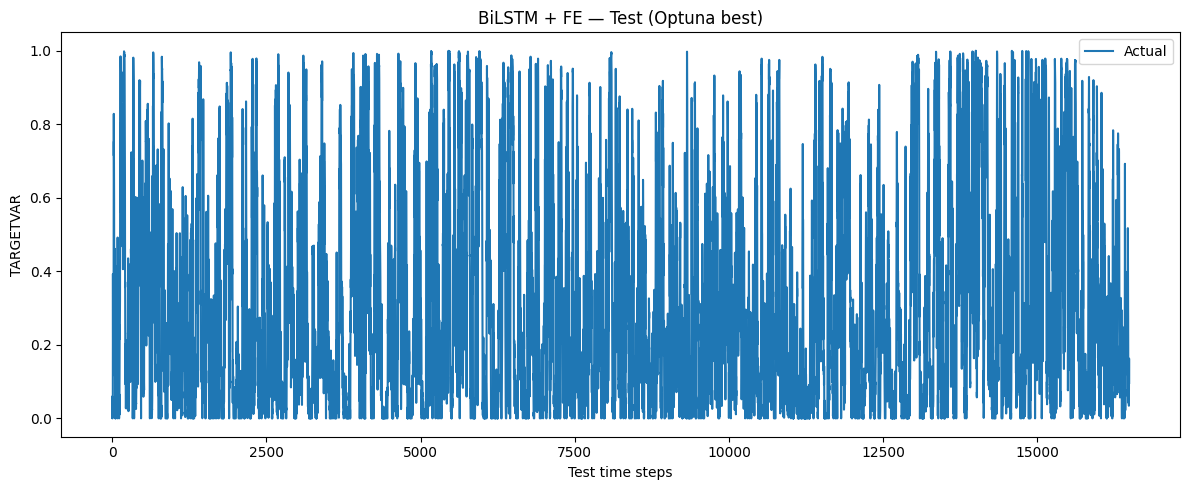

In [5]:
import matplotlib.pyplot as plt

y_true = df_pred["y_true"]

plt.figure(figsize=(12,5))
plt.plot(y_true, label="Actual")
#plt.plot(y_pred, label="Pred (best Optuna)")
plt.title("BiLSTM + FE — Test (Optuna best)")
plt.xlabel("Test time steps"); plt.ylabel(TARGET_COL)
plt.legend(); plt.tight_layout()
#plt.savefig(outdir / "biLSTM/test_plot_optuna.png", dpi=150)

In [6]:
import pandas as pd

# Optional: provide a 3-row frame with columns U10,V10,U100,V100 for better exogenous input
fw_3 = pd.DataFrame([
    {"U10": 3.0, "V10": -0.6, "U100": 4.7, "V100": -1.3},
    {"U10": 3.1, "V10": -0.5, "U100": 4.8, "V100": -1.2},
    {"U10": 3.2, "V10": -0.4, "U100": 4.9, "V100": -1.1},
])

df_fore = forecast_multi_steps(
    model_root=".",
    df_history=hist,
    H=3,
    future_weather_seq=None      # or fw_3
)
print(df_fore)


TypeError: '<' not supported between instances of 'Timestamp' and 'str'

In [7]:
df_pred = predict_over_file(model_root=".", data_path=r"E:\WindPowerForecastingData.xlsx")

import numpy as np

# Align arrays (if needed)
min_len = min(len(df_pred["y_true"]), len(df_pred["y_pred"]))
y_true_aligned = np.asarray(df_pred["y_true"]).reshape(-1)[:min_len]
y_pred_aligned = np.asarray(df_pred["y_pred"]).reshape(-1)[:min_len]

# Save to CSV
forecast_df = pd.DataFrame({
    "TIMESTAMP": df_pred["TIMESTAMP"].values[:min_len],
    "Actual": y_true_aligned,
    "Predicted": y_pred_aligned
})
forecast_df.to_csv("forecast_results_biglstm.csv", index=False)


C:\Users\Asus X513\AppData\Local\Temp\ipykernel_9480\2231355896.py:270: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce", infer_datetime_format=True)
